<a href="https://colab.research.google.com/github/brainmentorspvtltd/ML_OnlineFDP/blob/master/CNN_Traffic_SignDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os

In [0]:
os.environ['KAGGLE_USERNAME'] = 'your_username_on_kaggle'
os.environ['KAGGLE_KEY'] = 'api_key_provided_by_kaggle'
!kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

 98% 597M/612M [00:05<00:00, 142MB/s]
100% 612M/612M [00:05<00:00, 125MB/s]


In [0]:
!unzip gtsrb-german-traffic-sign.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/5/00005_00053_00011.png  
  inflating: train/5/00005_00053_00012.png  
  inflating: train/5/00005_00053_00013.png  
  inflating: train/5/00005_00053_00014.png  
  inflating: train/5/00005_00053_00015.png  
  inflating: train/5/00005_00053_00016.png  
  inflating: train/5/00005_00053_00017.png  
  inflating: train/5/00005_00053_00018.png  
  inflating: train/5/00005_00053_00019.png  
  inflating: train/5/00005_00053_00020.png  
  inflating: train/5/00005_00053_00021.png  
  inflating: train/5/00005_00053_00022.png  
  inflating: train/5/00005_00053_00023.png  
  inflating: train/5/00005_00053_00024.png  
  inflating: train/5/00005_00053_00025.png  
  inflating: train/5/00005_00053_00026.png  
  inflating: train/5/00005_00053_00027.png  
  inflating: train/5/00005_00053_00028.png  
  inflating: train/5/00005_00053_00029.png  
  inflating: train/5/00005_00054_00000.png  
  inflating: train/5/00005_00054_00001.png  
  in

In [0]:
from PIL import Image
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [0]:
df = pd.read_csv('Train.csv')

In [0]:
df.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png


In [0]:
img = Image.open(df['Path'][0])

In [0]:
# np.array(img)

In [0]:
train_images = []
train_labels = []

for i in range(len(df)):
  # Open Image using PIL Package
  img = Image.open(df['Path'].iloc[i])
  # Resize image, because all images has different width and height
  img = img.resize((32,32))
  train_images.append(np.array(img))
  train_labels.append(df['ClassId'].iloc[i])

In [0]:
test_df = pd.read_csv('Test.csv')

In [0]:
test_images = []
test_labels = []

for i in range(len(test_df)):
  img = Image.open(test_df['Path'].iloc[i])
  img = img.resize((32,32))
  test_images.append(np.array(img))
  test_labels.append(test_df['ClassId'].iloc[i])

In [0]:
train_images = np.asarray(train_images)
test_images = np.asarray(test_images)

In [0]:
train_images.shape

(39209, 32, 32, 3)

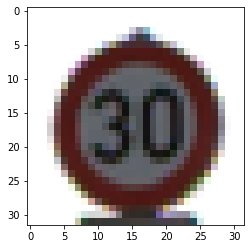

In [0]:
plt.imshow(train_images[1250])

In [0]:
from sklearn.preprocessing import OneHotEncoder

In [0]:
enc = OneHotEncoder()
train_labels = np.reshape(train_labels, (-1,1))
test_labels = np.reshape(test_labels, (-1,1))

train_labels = enc.fit_transform(train_labels).toarray()
test_labels = enc.fit_transform(test_labels).toarray()

In [0]:
train_labels[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [0]:
import tensorflow as tf

In [0]:
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from tensorflow.keras import Model

In [0]:
train_images = train_images / 255.0
test_image = test_images / 255.0

In [0]:
test_images.shape

(12630, 32, 32, 3)

In [0]:
train_df =  tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(10000).batch(32)

In [0]:
class MyModel(Model):
  def __init__(self):
    super().__init__()
    self.conv1 = Conv2D(32, 3, padding = 'same', activation = 'relu')
    self.pool1 = MaxPool2D((2,2))
    self.conv2 = Conv2D(64, 3, padding = 'same', activation = 'relu')
    self.pool2 = MaxPool2D((2,2))
    self.flatten = Flatten()
    self.dense1 = Dense(256, activation = 'relu')
    self.dense2 = Dense(128, activation = 'relu')
    self.dense3 = Dense(43, activation = 'softmax')

  def call(self,x):
    x = self.conv1(x)
    x = self.pool1(x)
    x = self.conv2(x)
    x = self.pool2(x)
    x = self.flatten(x)
    x = self.dense1(x)
    x = self.dense2(x)
    x = self.dense3(x)
    return x

In [0]:
model = MyModel()

In [0]:
loss_object = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.CategoricalAccuracy(name = 'train_acc')

In [0]:
# Decorators
@tf.function
def train_step(images, labels):
  with tf.GradientTape() as tape:
    predictions = model(images)
    loss = loss_object(labels, predictions)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients((zip(gradients, model.trainable_variables)))

  train_loss(loss)
  train_accuracy(labels, predictions)

In [0]:
epochs = 5
for epoch in range(epochs):
  for images, labels in train_df:
    train_step(images, labels)

  model.save_weights('/content', save_format='tf')

  print("Epochs : ",epoch, "Loss : ",train_loss.result(), "Accuracy : ",train_accuracy.result())
  train_loss.reset_states()
  train_accuracy.reset_states()

Epochs :  0 Loss :  tf.Tensor(0.089333355, shape=(), dtype=float32) Accuracy :  tf.Tensor(0.86063147, shape=(), dtype=float32)
Epochs :  1 Loss :  tf.Tensor(0.046206467, shape=(), dtype=float32) Accuracy :  tf.Tensor(0.9869928, shape=(), dtype=float32)
Epochs :  2 Loss :  tf.Tensor(0.030355072, shape=(), dtype=float32) Accuracy :  tf.Tensor(0.9912265, shape=(), dtype=float32)
Epochs :  3 Loss :  tf.Tensor(0.024991827, shape=(), dtype=float32) Accuracy :  tf.Tensor(0.9929098, shape=(), dtype=float32)
Epochs :  4 Loss :  tf.Tensor(0.02326859, shape=(), dtype=float32) Accuracy :  tf.Tensor(0.9930628, shape=(), dtype=float32)


In [0]:
predictions = np.argmax(model(test_image), axis=1)

In [0]:
predictions[0]

16

In [0]:
np.argmax(test_labels[0])

16